In [1]:
import numpy as np
import random
import math
import multiprocess as mp
import talib as ta
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime,date
from gga import GGA
from island_ga import IslandGGA  
from chromosome import Chromosome 

In [2]:
#rename column to remove spaces in column names
data=pd.read_csv('HistoricalQuotes.csv')
aapl =data.rename(columns={' Close/Last': 'close', ' Volume': 'volume',
                           ' Open':'open',' High':'high',' Low':'low'})
                        

#change date string into date format and sort the dataframe in ascending order
aapl[['Date']] = aapl[['Date']].applymap(lambda x: datetime.strptime(x,'%m/%d/%Y').date())
aapl =aapl.sort_values(by='Date')
#change dataframe dtypes to float
cols = [i for i in aapl if i not in ['Date','volume']]
def to_float(x):
    x = x.strip()
    return float(x[1:])

aapl[cols]=aapl[cols].applymap(to_float)

#Create Signals using Talib library
aapl['5EMA'] = ta.SMA(np.array(aapl['close']),5)
aapl['20EMA'] = ta.EMA(np.array(aapl['close']), timeperiod = 20)
aapl['RSI'] = ta.RSI(np.array(aapl['close']), timeperiod = 14)
aapl['WILLR'] = ta.WILLR(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), timeperiod=14)
aapl['MOM'] = ta.MOM(np.array(aapl['close']), timeperiod=5)
aapl['CCI'] = ta.CCI(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), timeperiod=14)
aapl['SLOWK'],aapl['SLOWD'] = ta.STOCH(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), fastk_period=14, slowk_period=3, slowd_period=3)
aapl['MACD'],aapl['MACDSIGNAL'],aapl['MACDHIST'] = ta.MACD(np.array(aapl['close']), fastperiod=12, slowperiod=26, signalperiod=9)
aapl['DMI'] = ta.DX(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), timeperiod=14)   

In [3]:
#  """Based on parameter setting adopted in Chen et al (2021) """
def generate_candidate_trading_signals(data):
    """Based on parameter setting adopted in Chen et al (2021) """
    conditions ={'TS1':[
                (data['5EMA'] > data['20EMA']),
                (data['5EMA'] < data['20EMA'])],
                 'TS2':[
                (data['RSI'] > 30),
                (data['RSI'] < 70),
                ],
                 'TS3':[
                (data['WILLR'] < 80),
                (data['WILLR'] > 20),
                ],
                 'TS4':[
                (data['MOM'] > 0 ),
                (data['MOM'] <= 0),
                ],
                 'TS5': [
                (data['CCI'] > 100 ),
                (data['CCI'] <= 100),
                ],
                 'TS6': [
                (data['SLOWK'] > data['SLOWD']) & (data['SLOWD'] < 20),
                (data['SLOWK'] < data['SLOWD']) & (data['SLOWD'] > 80)],
                'TS7': [
                (data['MACD'] > 0 ),
                (data['MACD'] <= 0)],
                'TS8': [
                (data['CCI'] > 100 ),
                (data['CCI'] <= -100)]}

    # create a list of the values we want to assign for each condition 1: buy, 0: sell
    values = [1, 0]

    # create a new column and use np.select to assign values to it using our lists as arguments
    for i in conditions:
        data[i] = np.select(conditions[i], values)
    strategies =list(conditions.keys())
    return data,strategies

In [4]:
#split data
train = aapl[(aapl['Date'] <= date(2016,12,31))]
test = aapl[(aapl['Date'] > date(2016,12,31))]
train_data, strategies =generate_candidate_trading_signals(train.copy())
test_data, test_strategies =generate_candidate_trading_signals(test.copy())
num_islands=3
num_iter=20
pSize=50
m_iter=5
N=5
K=3
r_cross=0.8
r_mut= 0.01
r_inv=0.3
n=4
b=4
stop_loss=-0.15
take_profit=0.15
allocated_capital=1000
islandgga = IslandGGA(num_islands,num_iter,train_data,strategies,pSize,m_iter,N,K,r_cross,r_mut,r_inv,n,b,stop_loss,take_profit,allocated_capital)

In [5]:
islandgga.evolve_master_slave()



In [30]:
GROUP =[['TS2', 'TS1', 'TS7', 'TS7'], ['TS3', 'TS4', 'TS7'], ['TS8', 'TS5', 'TS6', 'TS6']]
WEIGHT=[0, 0, 0, 0, 1, 0, 0]
FITNESS=0.0
SLTP=[1, 1, 1, 0, 1, 0, 0, 0]
print(pop[0])
pop[0].group_part = GROUP
pop[0].weight_part = WEIGHT
pop[0].sltp_part = SLTP
print("=====")
pop[0].calculate_chromosome_fitness(test_data,allocated_capital)
pop[0].fitness_value


SLTP: [1, 1, 1, 0, 1, 0, 0, 0]
GROUP: [['TS2', 'TS1', 'TS7', 'TS7'], ['TS3', 'TS4', 'TS7'], ['TS8', 'TS5', 'TS6', 'TS6']]
WEIGHT: [0, 0, 0, 0, 1, 0, 0]
FITNESS: 1.031653713683589
=====
profit: 115485.96953316449
corr: 126006.16261269519
gb: 1.0609581504393426
wb: 1


1.031653713683589

ITERATION: 1
ITERATION: 2
ITERATION: 3
ITERATION: 4


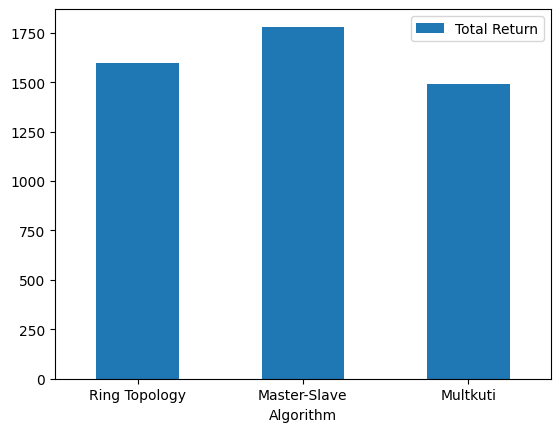

In [6]:
ring = []
master = []
multi = []
for i in range(4):
    islandgga.evolve_island_ring()
    best  = islandgga.globalBest
    ring.append(best.getProfit(test_data,allocated_capital))
    islandgga.evolve_master_slave()
    best  = islandgga.globalBest
    master.append(best.getProfit(test_data,allocated_capital))
    islandgga.evolve_island_multikuti()
    best  = islandgga.globalBest
    multi.append(best.getProfit(test_data,allocated_capital))
    print("ITERATION: {}".format(i+1))
    print("========================")
# multiple lines with legend
cols = ["Ring Topology","Master-Slave","Multkuti"]
df = pd.DataFrame({'Algorithm':cols, 'Total Return':[np.mean(ring),np.mean(master),np.mean(multi)]})
ax = df.plot.bar(x='Algorithm', y='Total Return', rot=0)

ITERATION: 1
ITERATION: 2
ITERATION: 3
ITERATION: 4
ITERATION: 5
ITERATION: 6
ITERATION: 7
ITERATION: 8
ITERATION: 9
ITERATION: 10
ITERATION: 11
ITERATION: 12
ITERATION: 13
ITERATION: 14
ITERATION: 15
ITERATION: 16
ITERATION: 17
ITERATION: 18
ITERATION: 19
ITERATION: 20
ITERATION: 21
ITERATION: 22
ITERATION: 23
ITERATION: 24
ITERATION: 25
ITERATION: 26
ITERATION: 27
ITERATION: 28
ITERATION: 29
ITERATION: 30
ITERATION: 31
ITERATION: 32
ITERATION: 33
ITERATION: 34
ITERATION: 35
ITERATION: 36
ITERATION: 37
ITERATION: 38
ITERATION: 39
ITERATION: 40
ITERATION: 41
ITERATION: 42
ITERATION: 43
ITERATION: 44
ITERATION: 45
ITERATION: 46
ITERATION: 47
ITERATION: 48
ITERATION: 49
ITERATION: 50
ITERATION: 51
ITERATION: 52
ITERATION: 53
ITERATION: 54
ITERATION: 55
ITERATION: 56
ITERATION: 57
ITERATION: 58
ITERATION: 59
ITERATION: 60
ITERATION: 61
ITERATION: 62
ITERATION: 63
ITERATION: 64
ITERATION: 65
ITERATION: 66
ITERATION: 67
ITERATION: 68
ITERATION: 69
ITERATION: 70
ITERATION: 71
ITERATION: 72
I

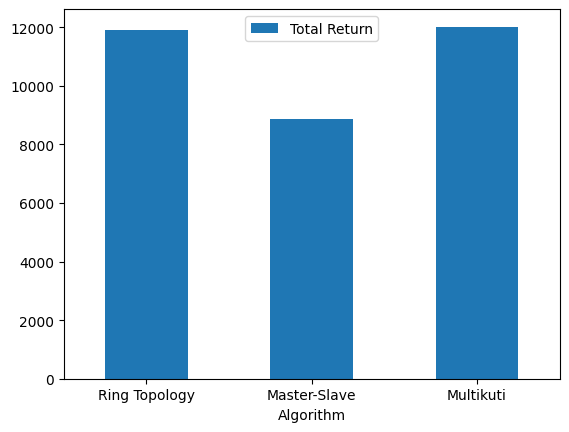

In [14]:
ring = []
master = []
multi = []
for i in range(80):
    islandgga.evolve_island_ring()
    best  = islandgga.globalBest
    ring.append(best)
    islandgga.evolve_master_slave()
    best  = islandgga.globalBest
    master.append(best)
    islandgga.evolve_island_multikuti()
    best  = islandgga.globalBest
    multi.append(best)
    print("ITERATION: {}".format(i+1))
    print("========================")
p_ring = []
p_master = []
p_multi = []
for i in range(80):
    p_ring.append(ring[i].getProfit(test_data,allocated_capital))
    p_master.append(master[i].getProfit(test_data,allocated_capital))
    p_multi.append(multi[i].getProfit(test_data,allocated_capital))
# multiple lines with legend
cols = ["Ring Topology","Master-Slave","Multikuti"]
df = pd.DataFrame({'Algorithm':cols, 'Total Return':[np.mean(p_ring),np.mean(p_master),np.mean(p_multi)]})
ax = df.plot.bar(x='Algorithm', y='Total Return', rot=0)

<AxesSubplot: >

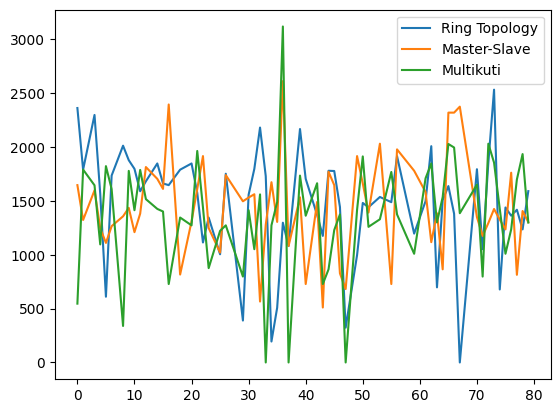

In [59]:
cols = ["Ring Topology","Master-Slave","Multikuti"]
df = pd.DataFrame({'Algorithm':cols, 'Total Return':[p_ring,p_master,p_multi]})
df = pd.DataFrame(np.column_stack([p_ring,p_master,p_multi]), 
                               columns=cols)
df = df[df[cols] < 20000]
df =df.dropna(axis = 0, how ='any')
df.plot()